In [1]:
import os
import re
from datetime import datetime

from dateutil import parser
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import statsmodels.stats.multitest as stats
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

In [2]:
matplotlib.rc('xtick', labelsize=10)

In [3]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["xtick.direction"] = "inout"
plt.rcParams["ytick.direction"] = "inout"

In [4]:
# sns.set(font='Times New Roman')

In [5]:
output_dir = '/Users/estorrs/Documents/emily-analysis/outputs'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [6]:
df = pd.read_csv('/Users/estorrs/Downloads/storm_results_190611_correctionLT3.csv', sep=',', encoding='latin')
df.columns = ['Site' if c == 'site' else c for c in df.columns]
# remove nests
for s in ['SGR', 'GGW', 'DCL']:
    df = df[df['Site'] != s]
print(df.shape)
df.head()

(114, 37)


,Site,Impervious surface (%),Number of karst features,Number of sinkholes,Forest cover (%),Developed open space (%),Watershed area (km2),nest,time_start,time_lamber_-5hr,...,Def_type,notes,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,BON,7.1,8,1,54.84,12.95,29.266887,NaN,10/6/2018 23:51,10/6/2018 18:51,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BON,7.1,8,1,54.84,12.95,29.266887,NaN,6/25/2018 17:55,6/26/2018 6:51,...,1,kept 6/19 BF value; compound storm with antece...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BON,7.1,8,1,54.84,12.95,29.266887,NaN,8/29/2018 5:40,8/29/2018 6:51,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BON,7.1,8,1,54.84,12.95,29.266887,NaN,8/10/2018 12:05,8/10/2018 18:51,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BON,7.1,8,1,54.84,12.95,29.266887,NaN,6/19/2018 18:55,6/19/2018 18:51,...,1,95% BF not achieved before next storm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['Site', 'Impervious surface (%)', 'Number of karst features',
       'Number of sinkholes', 'Forest cover (%)', 'Developed open space (%)',
       'Watershed area (km2)', 'nest', 'time_start', 'time_lamber_-5hr',
       'Lambert_ppt_mm', 'Lag time (minutes)', 'time_end_est1',
       'time_end_5%peak', 'time_end_95_BF_2hr', 'time_peak',
       'Peak Discharge (m3/s)', '5%_peak', 'Peak discharge (m3/s)',
       'Baseflow at peakflow', 'Area normmalized baseflow at peakflow',
       'time_Bfmin', 'Baseflow minimum', 'Baseflow with 5peak method',
       'Baseflow with 95_2hr method', 'adjusted 95_2hr with 5peak',
       'Total baseflow (%)', 'Def_type', 'notes', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
       'Unnamed: 35', 'Unnamed: 36'],
      dtype='object')

In [8]:
to_keep = ['Site', 'Impervious surface (%)', 'Number of karst features', 'Number of sinkholes', 'Forest cover (%)',
           'Developed open space (%)', 'Watershed area (km2)', 'time_start', 'Lag time (minutes)',
           'Peak Discharge (m3/s)', 'Peak discharge (m3/s)', 'Baseflow at peakflow',
           'Area normmalized baseflow at peakflow', 'Baseflow minimum', 'Baseflow with 5peak method',
           'Baseflow with 95_2hr method', 'Total baseflow (%)'
          ]

df = df[to_keep]
df.head()

,Site,Impervious surface (%),Number of karst features,Number of sinkholes,Forest cover (%),Developed open space (%),Watershed area (km2),time_start,Lag time (minutes),Peak Discharge (m3/s),Peak discharge (m3/s),Baseflow at peakflow,Area normmalized baseflow at peakflow,Baseflow minimum,Baseflow with 5peak method,Baseflow with 95_2hr method,Total baseflow (%)
0,BON,7.1,8,1,54.84,12.95,29.266887,10/6/2018 23:51,1099.0,37.3,1.056218,0.250752,9.050000e-09,0.249851,0.633895,NaN,0.633895
1,BON,7.1,8,1,54.84,12.95,29.266887,6/25/2018 17:55,999.0,40.4,1.144001,0.743809,2.910000e-08,0.528397,0.676582,NaN,0.676582
2,BON,7.1,8,1,54.84,12.95,29.266887,8/29/2018 5:40,299.0,69.7,1.973684,0.654410,4.410000e-08,0.273620,0.628588,0.663801,0.628588
3,BON,7.1,8,1,54.84,12.95,29.266887,8/10/2018 12:05,NaN,88.8,2.514536,0.626000,5.380000e-08,0.624000,0.706497,0.716926,0.706497
4,BON,7.1,8,1,54.84,12.95,29.266887,6/19/2018 18:55,789.0,107.0,3.029903,0.640334,6.630000e-08,0.359453,0.581110,NaN,0.581110


In [9]:
def bin_date_storm(n):
    if n in [12.0, 1.0, 2.0]:
        return 'winter'
    elif n in [3.0, 4.0, 5.0]:
        return 'spring'
    elif n in [6.0, 7.0, 8.0]:
        return 'summer'
    elif n in [9.0, 10.0, 11.0]:
        return 'fall'
    
    return np.nan

def bin_ISA(n):
    if n > 30:
        return 'urban'
    elif n > 20:
        return 'suburban'
    elif n > 0:
        return 'rural'
    
    return np.nan

def datetime_string_to_month(datetime_str):
    
#     print(datetime_str)
    d = parser.parse(datetime_str)
    
    return d.month

df['date_storm'] = [d if pd.isna(d) else datetime_string_to_month(d) for d in df['time_start']]
df['Season'] = [bin_date_storm(n) for n in df['date_storm']]

df['Land use'] = [n if pd.isna(n) else bin_ISA(n)
                            for n in df['Impervious surface (%)']]

In [10]:
#Convert Baseflow minimum, Baseflow at Peakflow and Total baseflow (%) from fraction to a percent.
for c in ['Baseflow minimum', 'Baseflow at peakflow', 'Total baseflow (%)']:
    df[c] = [x * 100 for x in df[c]]

df.head()

,Site,Impervious surface (%),Number of karst features,Number of sinkholes,Forest cover (%),Developed open space (%),Watershed area (km2),time_start,Lag time (minutes),Peak Discharge (m3/s),Peak discharge (m3/s),Baseflow at peakflow,Area normmalized baseflow at peakflow,Baseflow minimum,Baseflow with 5peak method,Baseflow with 95_2hr method,Total baseflow (%),date_storm,Season,Land use
0,BON,7.1,8,1,54.84,12.95,29.266887,10/6/2018 23:51,1099.0,37.3,1.056218,25.075182,9.050000e-09,24.985144,0.633895,NaN,63.389472,10,fall,rural
1,BON,7.1,8,1,54.84,12.95,29.266887,6/25/2018 17:55,999.0,40.4,1.144001,74.380883,2.910000e-08,52.839741,0.676582,NaN,67.658231,6,summer,rural
2,BON,7.1,8,1,54.84,12.95,29.266887,8/29/2018 5:40,299.0,69.7,1.973684,65.441010,4.410000e-08,27.361970,0.628588,0.663801,62.858754,8,summer,rural
3,BON,7.1,8,1,54.84,12.95,29.266887,8/10/2018 12:05,NaN,88.8,2.514536,62.600000,5.380000e-08,62.400000,0.706497,0.716926,70.649686,8,summer,rural
4,BON,7.1,8,1,54.84,12.95,29.266887,6/19/2018 18:55,789.0,107.0,3.029903,64.033367,6.630000e-08,35.945272,0.581110,NaN,58.111024,6,summer,rural


In [11]:
ts = list(set([t for t in zip(df['Site'], df['Impervious surface (%)']) if not pd.isna(t[0])]))
# site_order = [s for s, _ in sorted(ts, key=lambda x:x[1])]
hue_order = [s for s, _ in sorted(ts, key=lambda x:x[1])]
hue_order

['FOX', 'BON', 'KFR', 'CLKS', 'GGVP', 'CCC', 'LDC', 'FPT']

In [12]:
# want for baseflow minimum, baseflow at peakflow, area normalized baseflow at peakflow, total baseflow and lag time

# Also want these plots with forest cover, number of karst features, and open space as explanatory variables. ISA

dependent = ['Baseflow minimum', 'Baseflow at peakflow', 'Area normmalized baseflow at peakflow',
              'Total baseflow (%)', 'Lag time (minutes)']
explanitory = ['Impervious surface (%)', 'Forest cover (%)', 'Number of karst features', 'Developed open space (%)']

In [13]:
def get_site_to_color(df, var):
    ls = sns.color_palette("coolwarm", int(max(df[var])) + 1)
    site_to_color = {row['Site']:ls[int(row[var])]
                     for _, row in df.iterrows()
                     if not pd.isna(row['Site'])
                     if not pd.isna(row[var])}
    
    ts = list(set([t for t in zip(df['Site'], df[var]) if not pd.isna(t[0])]))
    site_order = [s for s, _ in sorted(ts, key=lambda x:x[1])]
    
    colors = [site_to_color[c] for c in site_order]

    return site_to_color, site_order

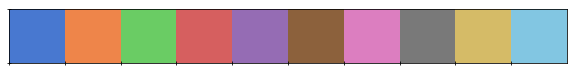

In [14]:
sns.palplot(sns.color_palette("muted", 10))

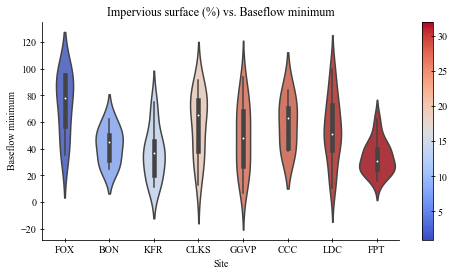

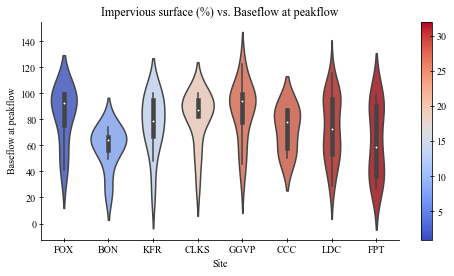

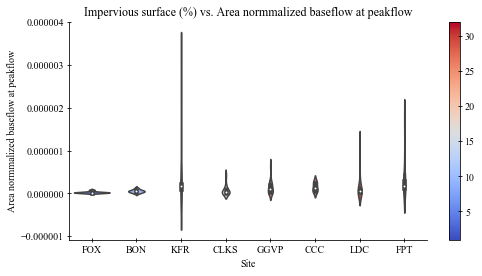

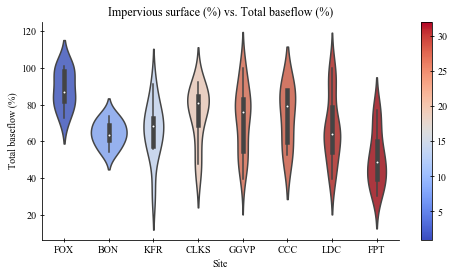

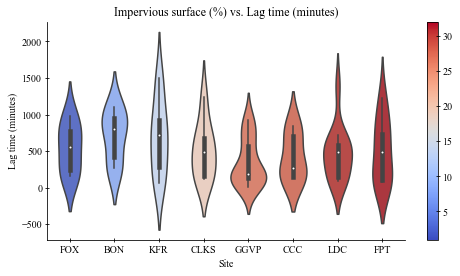

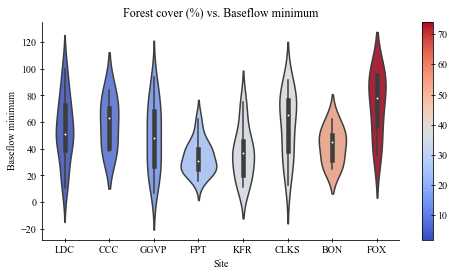

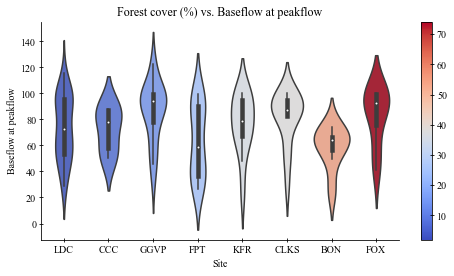

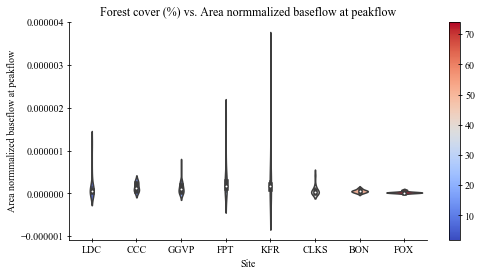

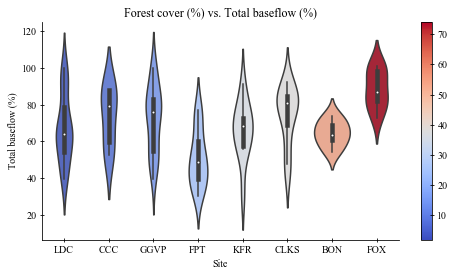

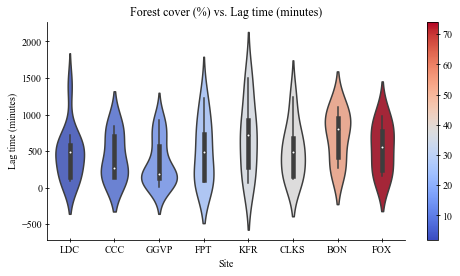

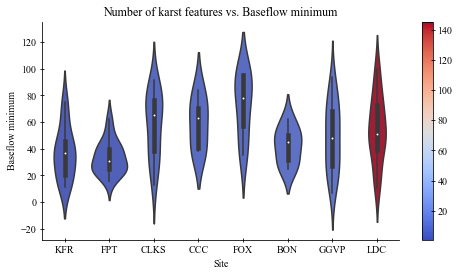

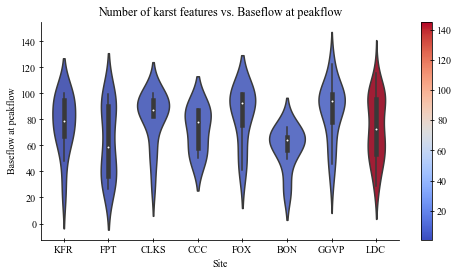

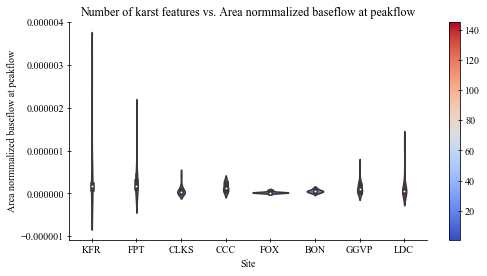

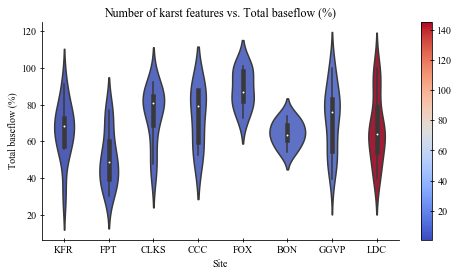

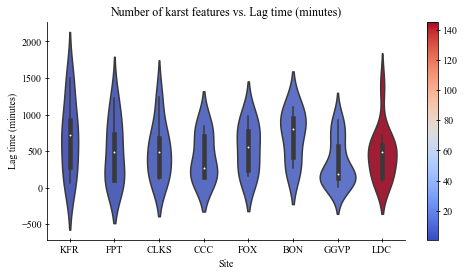

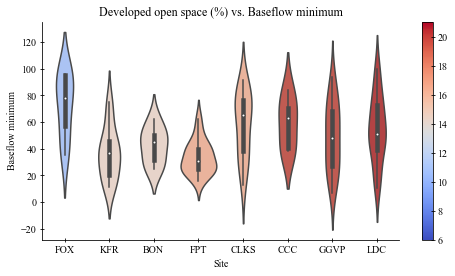

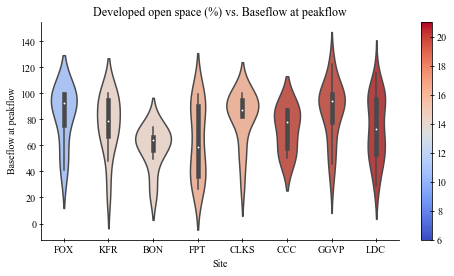

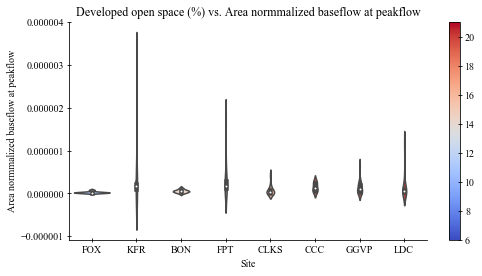

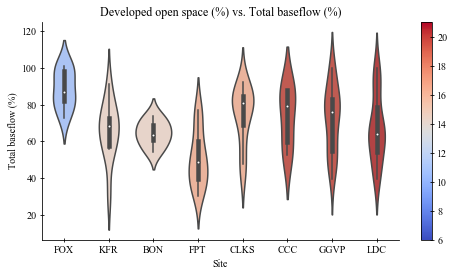

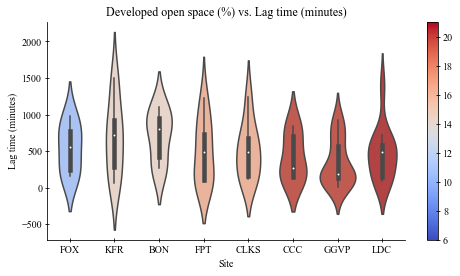

In [15]:
def create_figure(df, x, y):
    mini_df = df[[x, y, 'Site']].dropna()
    corr, p_value = scipy.stats.pearsonr(mini_df[x], mini_df[y])
    mini_df[x] = [int(val) for val in mini_df[x]]
    site_to_color, site_order = get_site_to_color(df, x)

#     order = sorted({val for val in mini_df[x]})
    
    fig, ax = plt.subplots(figsize=(8,4))
    
    axs = sns.violinplot(ax=ax, x='Site', y=y, data=mini_df, order=site_order, palette=site_to_color)
    
    norm = plt.Normalize(min(mini_df[x]), max(mini_df[x]))
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
    
    plt.title(f'{x} vs. {y}')
    
    
    sns.despine()
    
    plt.savefig(f'violinplot_{x}_{y}.pdf')
    
    return corr, p_value
    
es, ds, corrs, p_values = [], [], [], []
# create_figure(df, 'Impervious surface (%)', 'Baseflow minimum')
for e in explanitory:
    for d in dependent:  
        corr, p_value = create_figure(df, e, d)
        es.append(e)
        ds.append(d)
        corrs.append(corr)
        p_values.append(p_value)

In [16]:
stats_df = pd.DataFrame.from_dict({'explanitory': es, 'dependent': ds, 'correlation': corrs, 'p_value': p_values})
stats_df

,explanitory,dependent,correlation,p_value
0,Impervious surface (%),Baseflow minimum,-0.107491,0.254978
1,Impervious surface (%),Baseflow at peakflow,-0.044863,0.637041
2,Impervious surface (%),Area normmalized baseflow at peakflow,0.073831,0.451960
3,Impervious surface (%),Total baseflow (%),-0.280434,0.003437
4,Impervious surface (%),Lag time (minutes),-0.208423,0.083369
5,Forest cover (%),Baseflow minimum,0.064214,0.497286
6,Forest cover (%),Baseflow at peakflow,-0.006097,0.948896
7,Forest cover (%),Area normmalized baseflow at peakflow,-0.056597,0.564445
8,Forest cover (%),Total baseflow (%),0.182314,0.060175
9,Forest cover (%),Lag time (minutes),0.191795,0.111703


Lag time (minutes)


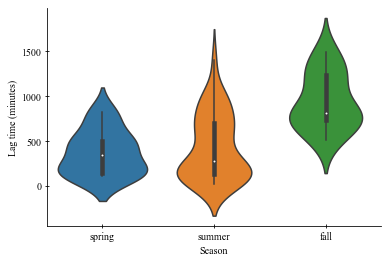

spring
mean: 366.8888888888889
median: 339.0
std: 238.15305276903314
spring vs. summer p_value: 0.5195348043626604
spring vs. fall p_value: 3.5243260384119342e-06

summer
mean: 428.05897435897435
median: 274.0
std: 358.44777734856655
summer vs. spring p_value: 0.5195348043626604
summer vs. fall p_value: 3.613969644861416e-05

fall
mean: 939.0
median: 804.0
std: 300.70430147085847
fall vs. spring p_value: 3.5243260384119342e-06
fall vs. summer p_value: 3.613969644861416e-05

Total baseflow (%)


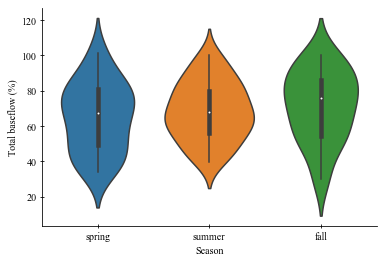

spring
mean: 65.02674286551725
median: 67.0580318
std: 19.237242171487285
spring vs. summer p_value: 0.42561446030950467
spring vs. fall p_value: 0.24929815720701115

summer
mean: 68.29046335849057
median: 67.6582305
std: 16.35385012131902
summer vs. spring p_value: 0.42561446030950467
summer vs. fall p_value: 0.4831111435914939

fall
mean: 71.31524453600001
median: 76.0
std: 19.602551731154445
fall vs. spring p_value: 0.24929815720701115
fall vs. summer p_value: 0.4831111435914939

Baseflow minimum


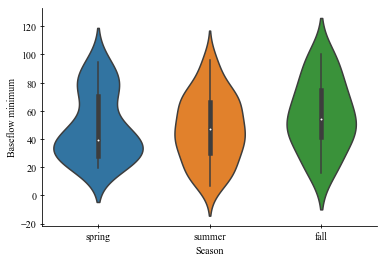

spring
mean: 48.75834756129033
median: 39.43230679999999
std: 23.339219231925963
spring vs. summer p_value: 0.7729601613278846
spring vs. fall p_value: 0.21766688371348006

summer
mean: 47.23431771403509
median: 47.0
std: 23.320179814188553
summer vs. spring p_value: 0.7729601613278846
summer vs. fall p_value: 0.09529977644656981

fall
mean: 56.797458203846155
median: 54.52920965
std: 24.36435043264889
fall vs. spring p_value: 0.21766688371348006
fall vs. summer p_value: 0.09529977644656981



In [17]:
y_vars = ['Lag time (minutes)', 'Total baseflow (%)', 'Baseflow minimum']

group_1s, group_2s, p_values = [], [], []
for y_variable in y_vars:
    print(y_variable)
#     ax = sns.violinplot(x="Season", y=y_variable, data=df,
#                        order=['spring', 'summer', 'fall'])
    ax = sns.violinplot(x="Season", y=y_variable, data=df,
                       order=['spring', 'summer', 'fall'])
    sns.despine()
                
    plt.savefig(f'Season_vs_{y_variable}.pdf')
    plt.show()
    
    for j in ['spring', 'summer', 'fall']:
        print(j)
        vals = [v for v in df[df['Season']==j][y_variable]
               if not pd.isna(v)]
        mean = np.average(vals)
        median = np.median(vals)
        std = np.std(vals)
        print(f'mean: {mean}')
        print(f'median: {median}')
        print(f'std: {std}')
        for k in ['spring', 'summer', 'fall']:
            if j != k:
                ls = [x for x in list(df[df['Season']==j][y_variable])
                     if not pd.isna(x)]
                xs = [x for x in list(df[df['Season']==k][y_variable])
                     if not pd.isna(x)]
                p_value = scipy.stats.ttest_ind(ls, xs)[1]
                print(f'{j} vs. {k} p_value: {p_value}')
        print()

In [18]:
colors = {
    'rural': sns.color_palette('muted', 4)[0],
    'suburban': sns.color_palette('muted', 4)[1],
    'urban': sns.color_palette('muted', 4)[3]
}

In [19]:
def output_stats(df, y_variable):
    for use in ['rural', 'suburban', 'urban']:
        for j in ['spring', 'summer', 'fall']:
            print(j, use)
            vals = [v for v in df[((df['Season']==j) & (df['Land use']==use))][y_variable]
                   if not pd.isna(v)]
            mean = np.average(vals)
            median = np.median(vals)
            std = np.std(vals)
            print(f'mean: {mean}')
            print(f'median: {median}')
            print(f'std: {std}')
            
            for u in ['rural', 'suburban', 'urban']:
                if u != use:
                    g1_vals = [x for x in list(df[((df['Season']==j) & (df['Land use']==use))][y_variable])
                               if not pd.isna(x)]
                    g2_vals = [x for x in list(df[((df['Season']==j) & (df['Land use']==u))][y_variable])
                               if not pd.isna(x)]
                    p_value = scipy.stats.ttest_ind(g1_vals, g2_vals)[1]
                    print(f'{j}_{use} vs. {j}_{u} p_value: {p_value}')
            
            
            for k in ['spring', 'summer', 'fall']:
                if j != k:
                    g1_vals = [x for x in list(df[((df['Season']==j) & (df['Land use']==use))][y_variable])
                               if not pd.isna(x)]
                    g2_vals = [x for x in list(df[((df['Season']==k) & (df['Land use']==use))][y_variable])
                               if not pd.isna(x)]

                    p_value = scipy.stats.ttest_ind(g1_vals, g2_vals)[1]
                    print(f'{j}_{use} vs. {k}_{use} p_value: {p_value}')
            print()

spring rural
mean: 449.85714285714283
median: 414.0
std: 246.45569208940037
spring_rural vs. spring_suburban p_value: 0.18539743207741208
spring_rural vs. spring_urban p_value: 0.5313627285435912
spring_rural vs. summer_rural p_value: 0.8351531807326669
spring_rural vs. fall_rural p_value: 0.0042867681950492795

summer rural
mean: 481.9533333333333
median: 464.0
std: 345.1656855611358
summer_rural vs. summer_suburban p_value: 0.223149360460356
summer_rural vs. summer_urban p_value: 0.9453660122488767
summer_rural vs. spring_rural p_value: 0.8351531807326669
summer_rural vs. fall_rural p_value: 0.002734492146304343

fall rural
mean: 1007.75
median: 951.5
std: 324.42978824392804
fall_rural vs. fall_suburban p_value: 0.2197854967700299
fall_rural vs. fall_urban p_value: 0.9192700949827891
fall_rural vs. spring_rural p_value: 0.0042867681950492795
fall_rural vs. summer_rural p_value: 0.002734492146304343

spring suburban
mean: 231.5
median: 156.5
std: 162.80740155164938
spring_suburban vs.

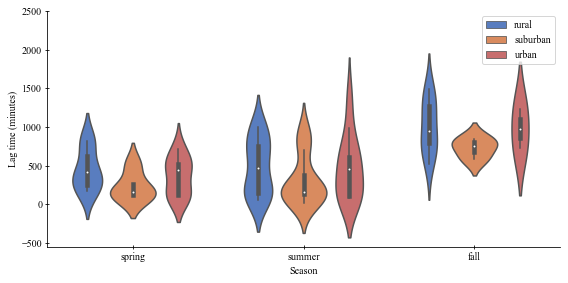

In [20]:
# for y_variable in y_vars:
y_variable = 'Lag time (minutes)'
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.violinplot(ax=ax, x="Season", y=y_variable, data=df, hue='Land use', palette=colors,
                   order=['spring', 'summer', 'fall'])
plt.legend(loc='upper right')
plt.tight_layout()
plt.ylim((-550, 2500))
sns.despine()
# plt.show()
plt.savefig(f'Season_plus_landuse_vs_{y_variable}.pdf')

output_stats(df, y_variable)


spring rural
mean: 76.5058576
median: 73.9539552
std: 12.071604151959281
spring_rural vs. spring_suburban p_value: 0.1868401249706246
spring_rural vs. spring_urban p_value: 0.006733808664835159
spring_rural vs. summer_rural p_value: 0.7371014299035454
spring_rural vs. fall_rural p_value: 0.12780490973903405

summer rural
mean: 74.66785563684212
median: 74.61965909999999
std: 14.742650264604178
summer_rural vs. summer_suburban p_value: 0.9196007449919671
summer_rural vs. summer_urban p_value: 0.0002530294077038931
summer_rural vs. spring_rural p_value: 0.7371014299035454
summer_rural vs. fall_rural p_value: 0.16345416818201328

fall rural
mean: 64.6606033875
median: 65.1912476
std: 18.39618366837899
fall_rural vs. fall_suburban p_value: 0.44157659573355035
fall_rural vs. fall_urban p_value: 0.28675615862038983
fall_rural vs. spring_rural p_value: 0.12780490973903405
fall_rural vs. summer_rural p_value: 0.16345416818201328

spring suburban
mean: 66.08600041999999
median: 65.8262654
std: 

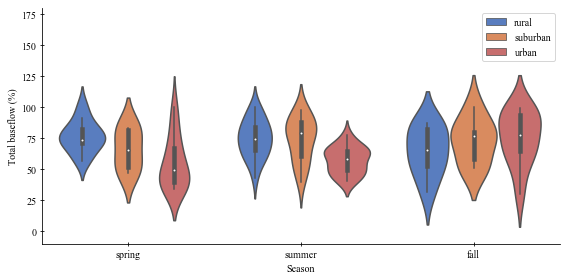

In [21]:
# for y_variable in y_vars:
y_variable = 'Total baseflow (%)'
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.violinplot(ax=ax, x="Season", y=y_variable, data=df, hue='Land use', palette=colors,
                   order=['spring', 'summer', 'fall'])
plt.legend(loc='upper right')
plt.tight_layout()
plt.ylim((-10, 180))
sns.despine()
# plt.show()
plt.savefig(f'Season_plus_landuse_vs_{y_variable}.pdf')

output_stats(df, y_variable)


spring rural
mean: 54.62461150909091
median: 45.7357915
std: 21.475917970135093
spring_rural vs. spring_suburban p_value: 0.601386202356005
spring_rural vs. spring_urban p_value: 0.2745307443549309
spring_rural vs. summer_rural p_value: 0.852817255697737
spring_rural vs. fall_rural p_value: 0.4159680381678218

summer rural
mean: 52.910307236363636
median: 51.1104375
std: 25.240443885911404
summer_rural vs. summer_suburban p_value: 0.7035568235933327
summer_rural vs. summer_urban p_value: 0.055438734363413386
summer_rural vs. spring_rural p_value: 0.852817255697737
summer_rural vs. fall_rural p_value: 0.480860658404866

fall rural
mean: 45.600121933333334
median: 45.3910582
std: 24.480627365775366
fall_rural vs. fall_suburban p_value: 0.357777565484126
fall_rural vs. fall_urban p_value: 0.0985063044997465
fall_rural vs. spring_rural p_value: 0.4159680381678218
fall_rural vs. summer_rural p_value: 0.480860658404866

spring suburban
mean: 47.60704331666667
median: 33.833789949999996
std: 

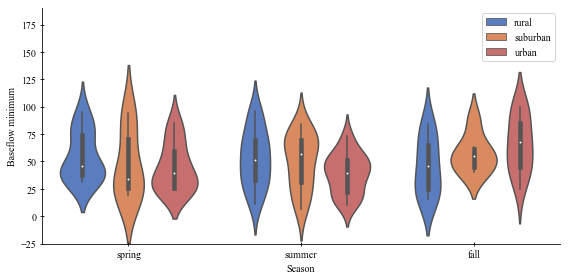

In [22]:
# for y_variable in y_vars:
y_variable = 'Baseflow minimum'
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.violinplot(ax=ax, x="Season", y=y_variable, data=df, hue='Land use', palette=colors,
                   order=['spring', 'summer', 'fall'])
sns.despine()
plt.legend(loc='upper right')
plt.tight_layout()
plt.ylim((-25, 190))
# plt.show()
plt.savefig(f'Season_plus_landuse_vs_{y_variable}.pdf')

output_stats(df, y_variable)


In [23]:
x = 'Baseflow with 5peak method'
y = 'Baseflow with 95_2hr method'

xs, ys = [], []
for x, y in zip(df[x], df[y]):
    if not pd.isna(x) and not pd.isna(y):
        xs.append(x)
        ys.append(y)
        
scipy.stats.ttest_rel(xs, ys)

Ttest_relResult(statistic=-2.1453753314680455, pvalue=0.03855340719193261)